### Import setting

In [224]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Define Runge and Runge'

Let
$R(x)= \frac{1}{1+25x^2}$,  $R'(x)= -\frac{50x}{(1 + 25x^2)^2}$

### Data preparation

In [225]:
def runge(x):
    return 1 / (1 + 25 * x**2)

def d_runge(x):
    return - 50 * x / (1 + 25 * x**2)**2

# Training data
N_train = 10000
x_train = torch.linspace(-1, 1, N_train).unsqueeze(1)
y_train = runge(x_train)
dy_train = d_runge(x_train)

# Validation data
N_val = 1500
x_val = torch.linspace(-1, 1, N_val).unsqueeze(1)
y_val = runge(x_val)
dy_val = d_runge(x_val)

### Network prepartion

In [226]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 6),
            nn.Tanh(),
            nn.Linear(6, 6),
            nn.Tanh(),
            nn.Linear(6, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

model = Net()


### Setting Derivative and Loss

In [227]:
def predict_and_derivative(model, x):
    x = x.clone().detach().requires_grad_(True)
    y = model(x)
    dy = torch.autograd.grad(
        outputs=y, inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]
    return y, dy

def total_loss(model, x, y_true, dy_true):
    y_pred, dy_pred = predict_and_derivative(model, x)
    loss_f = criterion(y_pred, y_true)
    loss_df = criterion(dy_pred, dy_true)
    return loss_f + lambda_deriv * loss_df, loss_f, loss_df


### Training

In [228]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_total, val_total = [], []
train_f, val_f = [], []
train_df, val_df = [], []
epochs = 7000
lambda_deriv = 1

for epoch in range(1, epochs+1):

    optimizer.zero_grad()
    loss_train, loss_f_train, loss_df_train = total_loss(model, x_train, y_train, dy_train)
    loss_train.backward()
    optimizer.step()
    
    loss_val, loss_f_val, loss_df_val = total_loss(model, x_val, y_val, dy_val)
    train_total.append(loss_train.item())
    val_total.append(loss_val.detach().item())
    train_f.append(loss_f_train.item())
    val_f.append(loss_f_val.detach().item())
    train_df.append(loss_df_train.item())
    val_df.append(loss_df_val.detach().item())
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Train Loss: {loss_train.item():.6f} (f: {loss_f_train.item():.6f}, df: {loss_df_train.item():.6f}) | "
              f"Val Loss: {loss_val.item():.6f} (f: {loss_f_val.item():.6f}, df: {loss_df_val.item():.6f})")

Epoch  500 | Train Loss: 0.393796 (f: 0.006009, df: 0.387787) | Val Loss: 0.388507 (f: 0.005948, df: 0.382559)
Epoch 1000 | Train Loss: 0.009154 (f: 0.000083, df: 0.009071) | Val Loss: 0.009142 (f: 0.000083, df: 0.009058)
Epoch 1500 | Train Loss: 0.004336 (f: 0.000041, df: 0.004295) | Val Loss: 0.004327 (f: 0.000041, df: 0.004286)
Epoch 2000 | Train Loss: 0.001464 (f: 0.000011, df: 0.001453) | Val Loss: 0.001461 (f: 0.000011, df: 0.001449)
Epoch 2500 | Train Loss: 0.000535 (f: 0.000003, df: 0.000532) | Val Loss: 0.000534 (f: 0.000003, df: 0.000531)
Epoch 3000 | Train Loss: 0.000292 (f: 0.000001, df: 0.000291) | Val Loss: 0.000292 (f: 0.000001, df: 0.000291)
Epoch 3500 | Train Loss: 0.000183 (f: 0.000001, df: 0.000182) | Val Loss: 0.000183 (f: 0.000001, df: 0.000182)
Epoch 4000 | Train Loss: 0.000110 (f: 0.000001, df: 0.000110) | Val Loss: 0.000110 (f: 0.000001, df: 0.000110)
Epoch 4500 | Train Loss: 0.000065 (f: 0.000000, df: 0.000065) | Val Loss: 0.000066 (f: 0.000000, df: 0.000065)
E

### Loss Curves

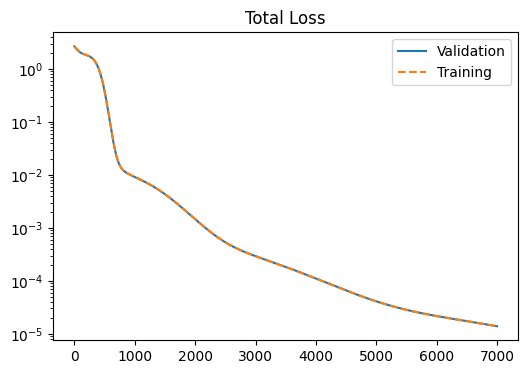

In [229]:
plt.figure(figsize=(6,4))
plt.plot(val_total, label="Validation")
plt.plot(train_total, "--", label="Training")
plt.yscale("log")
plt.title("Total Loss")
plt.legend()

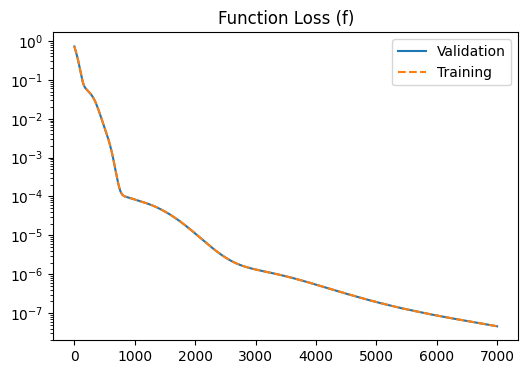

In [230]:
plt.figure(figsize=(6,4))
plt.plot(val_f, label="Validation")
plt.plot(train_f, "--", label="Training")
plt.yscale("log")
plt.title("Function Loss (f)")
plt.legend()

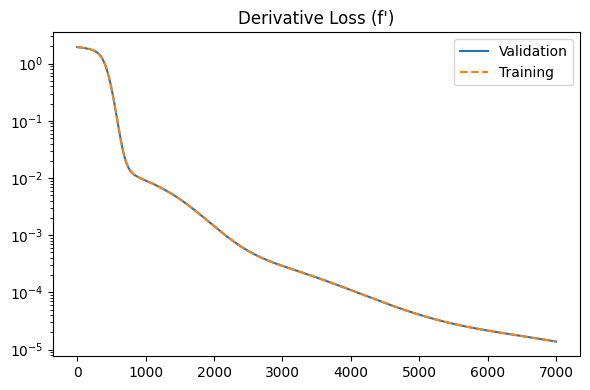

In [231]:
plt.figure(figsize=(6,4))
plt.plot(val_df, label="Validation")
plt.plot(train_df, "--", label="Training")
plt.yscale("log")
plt.title("Derivative Loss (f')")
plt.legend()

plt.tight_layout()
plt.show()

### Result

In [232]:
mse = criterion(y_pred, y_val).item()
max_err = torch.max(torch.abs(y_pred - y_val)).item()

print(f"MSE: {mse:.6f}, Max Error: {max_err:.6f}")

MSE: 0.000000, Max Error: 0.000624


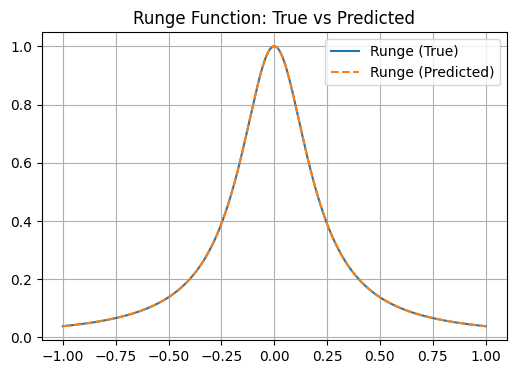

In [233]:
y_pred, dy_pred = predict_and_derivative(model, x_val)

plt.figure(figsize=(6,4))
plt.plot(x_val.numpy(), y_val.numpy(), label="Runge (True)")
plt.plot(x_val.detach().numpy(), y_pred.detach().numpy(), "--", label="Runge (Predicted)")
plt.title("Runge Function: True vs Predicted")
plt.legend()
plt.grid(True)

plt.show()

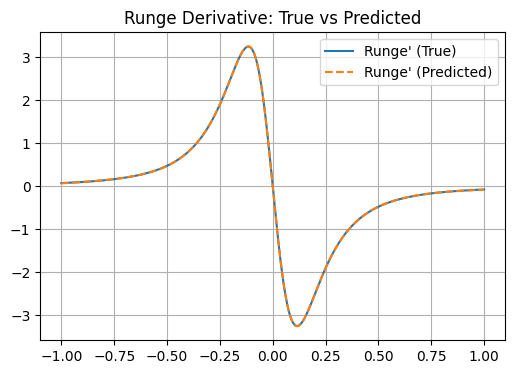

In [234]:
plt.figure(figsize=(6,4))
plt.plot(x_val.numpy(), dy_val.numpy(), label="Runge' (True)")
plt.plot(x_val.detach().numpy(), dy_pred.detach().numpy(), "--", label="Runge' (Predicted)")
plt.title("Runge Derivative: True vs Predicted")
plt.legend()
plt.grid(True)

plt.show()

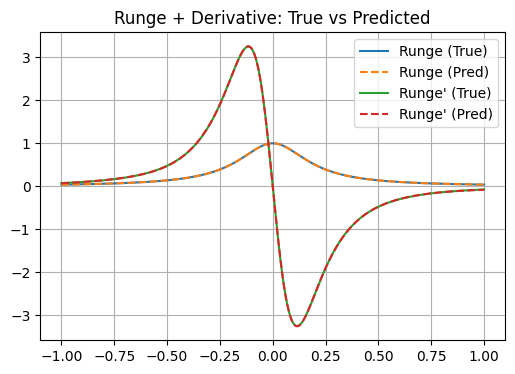

In [235]:
plt.figure(figsize=(6,4))
plt.plot(x_val.numpy(), y_val.numpy(), label="Runge (True)")
plt.plot(x_val.detach().numpy(), y_pred.detach().numpy(), "--", label="Runge (Pred)")
plt.plot(x_val.numpy(), dy_val.numpy(), label="Runge' (True)")
plt.plot(x_val.detach().numpy(), dy_pred.detach().numpy(), "--", label="Runge' (Pred)")
plt.title("Runge + Derivative: True vs Predicted")
plt.legend()
plt.grid(True)

plt.show()